In [ ]:
import pandas as pd

data = {
    "Action Space Type": ["Both", "Both", "Both", "Both", "Discrete", "Continuous", "Both", "Continuous", "Both", "Continuous", "Discrete"],
    "Key Innovation": [
        "Direct policy optimization with policy gradient. Introduced the idea of optimizing the policy directly using gradient ascent. Enabled learning in high-dimensional action spaces.",
        "Trust region optimization for stable learning. Introduced trust region methods to stabilize policy updates and prevent large policy changes that could lead to divergence.",
        "Clipped surrogate objective for stable learning. Addressed issues with trust region methods by using a clipped surrogate objective, ensuring monotonic improvement.",
        "Combines actor and critic for efficient training. Utilizes both value and policy networks to improve sample efficiency and convergence speed.",
        "Deep Q-network approximation of the Q-function. Introduced deep neural networks to approximate the Q-function, making it possible to handle high-dimensional state spaces.",
        "Continuous action space extension of DQN. Adapted DQN for continuous action spaces using actor-critic architecture and deterministic policy gradients.",
        "Asynchronous training of multiple agents. Parallelizes training by having multiple agents interact with their environments asynchronously, improving data efficiency.",
        "Entropy regularization for improved exploration. Encourages exploration by adding an entropy term to the objective function, balancing exploration and exploitation.",
        "Twin critics and delayed policy updates. Introduced twin Q-networks to improve stability and utilized delayed policy updates for better performance.",
        "Distributional value estimation with deterministic policy gradients. Estimated value distributions instead of single values and combined them with deterministic policy gradients for improved learning.",
        "Value iteration with Q-value updates. Introduced the concept of Q-values and iteratively updates Q-values using the Bellman equation for value estimation."
    ],
    "On - Off Policy": ["On", "On", "On", "On", "Off", "Off", "On", "Off", "On", "Off", "Off"],
    "Value / Policy Based": ["Policy", "Policy", "Policy", "Both", "Value", "Both", "Both", "Both", "Both", "Both", "Value"],
    "Year of Publication": [None, None, None, None, "2015", "2016", "2016", "2018", "2018", "2018", "1957"]
}

df = pd.DataFrame(data, index=["REINFORCE", "TRPO", "PPO", "A2C", "DQN", "DDPG", "A3C", "SAC", "TD3", "D4PG", "Q-Learning"])

df.head(11)

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from functions import *
from itertools import count
buyer_strategies = ['Honest', 'Random', 'Random', 'Random']
seller_strategies = ['Honest', 'Honest', 'Honest', 'Honest', 'Honest','Honest', 'Honest', 'Honest', 'Honest', 'Honest']
nbuyers, nsellers = len(buyer_strategies), len(seller_strategies)
nrounds, nperiods, ntokens, nsteps, gametype, nbuyers, nsellers = 10, 10, 8, 30, '1234', len(buyer_strategies), len(seller_strategies)
R1, R2, R3, R4 = gametype_to_ran(gametype)
game_metadata = [nrounds, nperiods, ntokens, nbuyers, nsellers, nsteps, R1, R2, R3, R4]
db = Database(game_metadata, buyer_strategies, seller_strategies)
rnd = 0
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
period = 0
num_states = nsteps
min_frac = 0.01
max_frac = 1.0

In [ ]:
class TradingEnv(gym.Env):
    def __init__(self, db, nsteps, render_mode = None):
        self.rnd = 0
        self.period = -1
        self.nperiods = nperiods
        self.db = db
        self.action_space = spaces.Box(0,1,(1,),dtype=np.float)
        self.observation_space = spaces.Box(-1,200,(13,),dtype=np.float32)

    def reset(self,seed=None):
        #self.db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
        self.db.reset_period(self.rnd)
        self.timestep = 0
        self.period += 1
        self.db.buyers[0].next_token()
        agent = self.db.buyers[0]
        observation = np.array([0,-1,-1,-1,-1,-1,-1,-1,agent.value,-1,-1,-1,agent.num_tokens_traded], dtype = np.float32)
        return observation, {}

    def step(self, action, seed=None, options=None):
        [buyer.next_token() for buyer in self.db.buyers]
        [seller.next_token() for seller in self.db.sellers]
        bid_frac = action.item()
        # convert action to bid
        self.db.buyers[0].next_token()
        min_bid = self.db.buyers[0].value * min_frac
        max_bid = self.db.buyers[0].value * max_frac
        bid = np.round(max_bid * bid_frac + (1 - bid_frac) * min_bid, 2)

        # simulate market
        bids = [buyer.bid(self.db) for buyer in self.db.buyers]
        bids[0] = bid
        asks = [seller.ask(self.db) for seller in self.db.sellers]
        current_ask, current_ask_idx, current_bid, current_bid_idx = current_bid_ask(bids, asks)
        sale, price, bprofit, sprofit, buy, sell = buy_sell(self.db, current_bid, current_bid_idx, current_ask, current_ask_idx)
        step_data = [self.rnd, self.period, self.timestep, bids, asks, current_bid, current_bid_idx, current_ask, current_ask_idx, buy, sell, price, sale, bprofit, sprofit]
        self.db.add_step(step_data)

        # compute reward, new state
        reward = 0.0
        if sale == 1 and current_bid_idx == 0:
            reward = bprofit
            
        agent = self.db.buyers[0]
        observation = np.array([self.timestep + 1, current_ask, current_ask_idx, current_bid, current_bid_idx,
                                sale, price, buy, sell, agent.value, agent.step_profit,
                                agent.sale, agent.num_tokens_traded],dtype = np.float32)
        idx = np.isnan(observation)
        observation[idx] = -1.0
        # check termination
        self.timestep += 1
        if self.timestep == nsteps:
            terminated = True
            self.timestep = 0
        else:
            terminated = False
        infos = {"TimeLimit.truncated":True}
        truncated = False
        return observation, reward, terminated, truncated, infos

In [ ]:
from stable_baselines3.common.env_checker import check_env
db = Database(game_metadata, buyer_strategies, seller_strategies)
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
env = TradingEnv(db, nsteps)
check_env(env)

In [ ]:
rnd = 0
db = Database(game_metadata, buyer_strategies, seller_strategies)
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
env = TradingEnv(db, nsteps)
observation, info = env.reset()
for period in count():
    for timestep in count(): 
        action = env.action_space.sample()
        observation, reward, done, info, _ = env.step(action)
        print(f"Rnd: {rnd}, Period: {period}, New State: {observation}, Action:{np.round(action,1)}, Reward: {np.round(reward,1)}, Period End: {done}")
        if done:
            # If the episode is done, reset the environment
            #print('done')
            observation, info = env.reset()
            break
    if period == nperiods:
        period = 0
        break
env.close()

In [ ]:
db.step_data.head(1000).groupby('current_bid_idx').sum()

In [ ]:
# Define your environment and parameters (replace with your actual environment setup)
rnd = 0
period = 0
num_states = nsteps
min_frac = 0.01
max_frac = 1.5
eval_steps = 1000
training_step = 50000

In [ ]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO, A2C, DQN, SAC
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.evaluation import evaluate_policy

### Continous Action Space

In [ ]:
from stable_baselines3 import SAC, DDPG, TD3, A2C, PPO
db = Database(game_metadata, buyer_strategies, seller_strategies)
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
env = TradingEnv(db, nsteps)
policy_kwargs = dict(net_arch=dict(pi=[128, 128], qf=[128, 128]))
model = SAC("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1,)
model.learn(50000, progress_bar = True)

In [54]:
model.learn(50000, progress_bar = False)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 123      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 61       |
|    time_elapsed    | 1        |
|    total_timesteps | 120      |
| train/             |          |
|    actor_loss      | -61.4    |
|    critic_loss     | 2.13     |
|    ent_coef        | 0.225    |
|    ent_coef_loss   | 0.0238   |
|    learning_rate   | 0.0003   |
|    n_updates       | 66929    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 177      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 44       |
|    time_elapsed    | 5        |
|    total_timesteps | 240      |
| train/             |          |
|    actor_loss      | -52.6    |
|    critic_loss     | 1.66     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 226      |
| time/              |          |
|    episodes        | 64       |
|    fps             | 29       |
|    time_elapsed    | 65       |
|    total_timesteps | 1920     |
| train/             |          |
|    actor_loss      | -58.3    |
|    critic_loss     | 2.01     |
|    ent_coef        | 0.221    |
|    ent_coef_loss   | -0.00154 |
|    learning_rate   | 0.0003   |
|    n_updates       | 68729    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 226      |
| time/              |          |
|    episodes        | 68       |
|    fps             | 28       |
|    time_elapsed    | 70       |
|    total_timesteps | 2040     |
| train/             |          |
|    actor_loss      | -61.8    |
|    critic_loss     | 2.31     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 233      |
| time/              |          |
|    episodes        | 124      |
|    fps             | 29       |
|    time_elapsed    | 126      |
|    total_timesteps | 3720     |
| train/             |          |
|    actor_loss      | -65.8    |
|    critic_loss     | 2.17     |
|    ent_coef        | 0.226    |
|    ent_coef_loss   | -0.0145  |
|    learning_rate   | 0.0003   |
|    n_updates       | 70529    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 233      |
| time/              |          |
|    episodes        | 128      |
|    fps             | 29       |
|    time_elapsed    | 130      |
|    total_timesteps | 3840     |
| train/             |          |
|    actor_loss      | -63.4    |
|    critic_loss     | 1.96     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 233      |
| time/              |          |
|    episodes        | 184      |
|    fps             | 30       |
|    time_elapsed    | 182      |
|    total_timesteps | 5520     |
| train/             |          |
|    actor_loss      | -61.4    |
|    critic_loss     | 2.16     |
|    ent_coef        | 0.223    |
|    ent_coef_loss   | -0.112   |
|    learning_rate   | 0.0003   |
|    n_updates       | 72329    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 233      |
| time/              |          |
|    episodes        | 188      |
|    fps             | 30       |
|    time_elapsed    | 187      |
|    total_timesteps | 5640     |
| train/             |          |
|    actor_loss      | -68.3    |
|    critic_loss     | 2.69     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 233      |
| time/              |          |
|    episodes        | 244      |
|    fps             | 29       |
|    time_elapsed    | 249      |
|    total_timesteps | 7320     |
| train/             |          |
|    actor_loss      | -70.9    |
|    critic_loss     | 1.87     |
|    ent_coef        | 0.225    |
|    ent_coef_loss   | 0.122    |
|    learning_rate   | 0.0003   |
|    n_updates       | 74129    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 233      |
| time/              |          |
|    episodes        | 248      |
|    fps             | 29       |
|    time_elapsed    | 252      |
|    total_timesteps | 7440     |
| train/             |          |
|    actor_loss      | -55.8    |
|    critic_loss     | 2.56     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 232      |
| time/              |          |
|    episodes        | 304      |
|    fps             | 29       |
|    time_elapsed    | 311      |
|    total_timesteps | 9120     |
| train/             |          |
|    actor_loss      | -57.6    |
|    critic_loss     | 1.81     |
|    ent_coef        | 0.226    |
|    ent_coef_loss   | -0.0878  |
|    learning_rate   | 0.0003   |
|    n_updates       | 75929    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 232      |
| time/              |          |
|    episodes        | 308      |
|    fps             | 29       |
|    time_elapsed    | 316      |
|    total_timesteps | 9240     |
| train/             |          |
|    actor_loss      | -64.1    |
|    critic_loss     | 1.9      |
|    ent_coef 

KeyboardInterrupt: 

In [57]:
db.step_data.head(600).groupby('current_bid_idx').sum()

,rnd,period,step,current_bid,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
current_bid_idx,,,,,,,,,,,,
0,0,1561,1231,13464.76,4568.4,811,152,160,8919.125,160,2196.875,4485.625
1,0,1380,1970,7284.90,5353.9,677,120,100,5365.800,120,2344.200,1237.400
2,0,1951,4472,7915.70,9283.4,1111,46,39,1949.050,46,713.750,365.750
3,0,808,1027,4173.70,2774.3,419,60,55,2692.750,60,1503.250,911.750


In [58]:
db.step_data.tail(600).groupby('current_bid_idx').sum()

,rnd,period,step,current_bid,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
current_bid_idx,,,,,,,,,,,,
0,0,405699,1775,7339.42,5242.2,727,140,116,5618.05,140,4681.95,1236.35
1,0,418375,2104,8050.80,5674.7,765,120,107,5236.20,120,2473.80,1578.90
2,0,502737,3900,7802.90,8189.4,759,50,47,2081.50,50,753.80,557.90
3,0,204089,921,4207.60,2562.0,328,60,56,2659.35,60,1536.65,1020.35


In [ ]:
db.round_data.redemption_values.item()

In [59]:
db.step_data.tail(60)

,rnd,period,step,bids,asks,current_bid,current_bid_idx,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
76771,0,2560,0,"[60.44, 48.5, 38.1, 58.7]","[25.9, 42.3, 45.1, 15.6, 14.8, 45.7, 25.6, 36....",60.44,0,14.8,4,True,True,37.620,1,55.780,22.820
76772,0,2560,1,"[55.42, 47.9, 32.2, 77.7]","[25.9, 42.3, 45.1, 15.6, 28.2, 45.7, 25.6, 36....",77.70,3,15.6,3,True,True,46.650,1,52.350,31.050
76773,0,2560,2,"[56.37, 79.1, 36.5, 38.0]","[25.9, 42.3, 45.1, 17.4, 28.2, 45.7, 25.6, 36....",79.10,1,17.4,3,True,True,48.250,1,35.150,30.850
76774,0,2560,3,"[56.76, 55.5, 60.1, 47.1]","[25.9, 42.3, 45.1, 29.1, 28.2, 45.7, 25.6, 36....",60.10,2,17.8,9,True,True,38.950,1,24.150,21.150
76775,0,2560,4,"[55.08, 79.1, 49.1, 53.5]","[25.9, 42.3, 45.1, 29.1, 28.2, 45.7, 25.6, 36....",79.10,1,25.6,6,True,True,52.350,1,26.850,26.750
76776,0,2560,5,"[52.37, 49.1, 29.1, 34.8]","[25.9, 42.3, 45.1, 29.1, 28.2, 45.7, 26.7, 36....",52.37,0,25.9,0,True,True,39.135,1,46.165,13.235
76777,0,2560,6,"[52.9, 37.0, 41.5, 44.4]","[38.7, 42.3, 45.1, 29.1, 28.2, 45.7, 26.7, 36....",52.90,0,26.7,6,True,True,39.800,1,38.600,13.100
76778,0,2560,7,"[50.01, 50.8, 47.2, 49.6]","[38.7, 42.3, 45.1, 29.1, 28.2, 45.7, 44.6, 36....",50.80,1,28.2,4,True,True,39.500,1,19.900,11.300
76779,0,2560,8,"[49.84, 39.6, 44.8, 57.2]","[38.7, 42.3, 45.1, 29.1, 39.8, 45.7, 44.6, 36....",57.20,3,29.1,3,True,True,43.150,1,14.450,14.050
76780,0,2560,9,"[47.02, 30.0, 38.4, 46.6]","[38.7, 42.3, 45.1, 60.4, 39.8, 45.7, 44.6, 36....",47.02,0,30.2,8,True,True,38.610,1,35.890,8.410


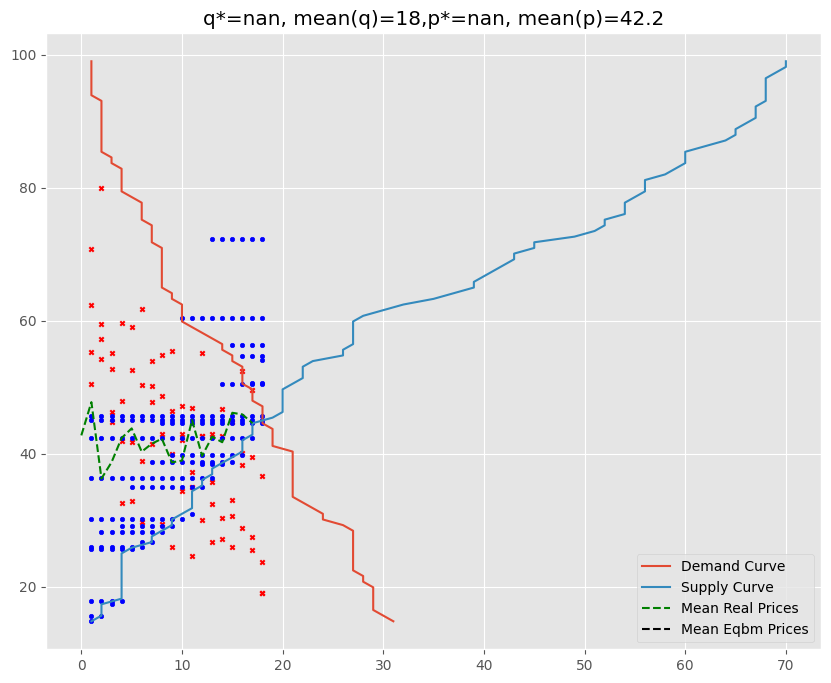

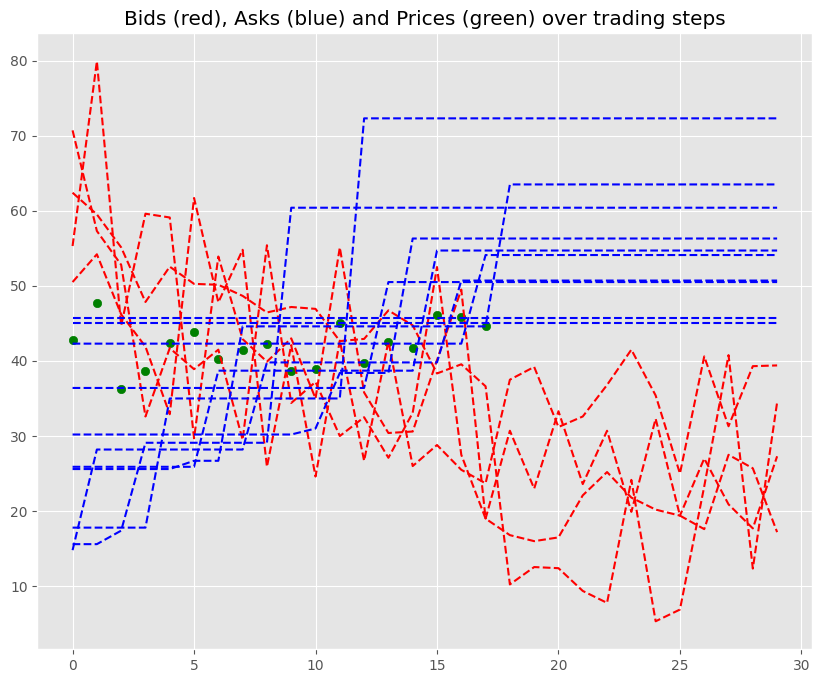

In [60]:
graph_period(env.db, 0, 2561)

### Discrete Action Spaces

In [ ]:
from stable_baselines3 import DQN
db = Database(game_metadata, buyer_strategies, seller_strategies)
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
env = TradingEnv(db, nsteps)
env.action_space = spaces.Discrete(51)
#policy_kwargs = dict(net_arch=dict(pi=[64, 64], qf=[64, 64]))
model = DQN("MlpPolicy", env, verbose=1,)
model.learn(50000, progress_bar = False)

In [ ]:
db.step_data.head(100).groupby('current_bid_idx').sum()

In [ ]:
db.step_data.tail(100).groupby('current_bid_idx').sum()

## ON POLICY

### DDPG - Deterministic Deep Policy Gradient

In [ ]:
from stable_baselines3 import DDPG
db = Database(game_metadata, buyer_strategies, seller_strategies)
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
env = TradingEnv(db, nsteps)
policy_kwargs = dict(net_arch=dict(pi=[64, 64], qf=[64, 64]))
model = DDPG("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1,)
model.learn(50000, progress_bar = True)

In [ ]:
db.step_data.head(100).groupby('current_bid_idx').sum()

In [ ]:
db.step_data.tail(100).groupby('current_bid_idx').sum()

### PPO - Proximal Policy Optimization

In [ ]:
from stable_baselines3 import PPO
db = Database(game_metadata, buyer_strategies, seller_strategies)
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
env = TradingEnv(db, nsteps)
policy_kwargs = dict(net_arch=dict(pi=[64, 64], qf=[64, 64]))
model = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(50000, progress_bar = False)

### A2C - Advantage Actor-Critic

In [ ]:
# Create A2C model
from stable_baselines3.ppo.policies import MlpPolicy
a2c_model = A2C(MlpPolicy, env, verbose=0)

# Train the A2C agent for 10000 steps
a2c_model.learn(total_timesteps=training_step, progress_bar = True)

# Evaluate the trained A2C agent
mean_reward_a2c, std_reward_a2c = evaluate_policy(a2c_model, env, n_eval_episodes=eval_steps)
print(f"A2C mean_reward: {mean_reward_a2c:.2f} +/- {std_reward_a2c:.2f}")